<center> <h1> <strong>CV ASSIGNMENT</strong></h1></center>



# Tweets Entities Extraction and Sentiments Analysis

### Note:

This Notebook Aims to solve two objectives:
* Objective 1: Count the number of rice grains in the Image.
* Objective 2: Find the number of broken grains in the image.


Technology used:  Computer Vision, OpenCv, WaterShed Algorithm, Image Preprocessing, Image Segmentation, and others.

The Approach of the objectives are well elucidated and have clear Visualization for better Insights into the working of each notebook cell.

\
I hope you will love the approach and the presentation of the solution.
\
Thanks & Regards,\
Aman India.

\
**My handles**
> LinkedIn: https://www.linkedin.com/in/mramanindia/
\
> Github: https://github.com/mramanindia
\
> Mail: amanindiamuzz@gmail.com
\
> Kaggle: https://www.kaggle.com/amanindiamuz

---
# Image Information
* The background will always be blue.
* There will be a mix of broken and non-broken rice grains.
* The grains will not overlap but can touch each other.

# My Approach (Solution)
---

## The Steps involved in solving the Objectives are as follows:
1. **Importing Required Libraries**
2. **Defining Required Function**
  *  Defining custom "show" function for Image Visualization
2. **Image Pre-Processing**
  * GrayScale Conversion
  * Image Thresholding
  * Morphological Transformations (Noise Removal)
3. **Counting rice grains using the Contours method**
  * Working over Clear image to get insight into grain touching problem
3. **Applying Watershed Algorithm** (Solving grains touching problem)
  * Applying Watershed Algorithm for Solving Touching rice grains problem
  
4. **Counting total Rice grains and Broken Rice grains using the contour area**
  * For total rice grains counting: the Watershed method
  * For broken rice grains counting: A filter of an average area of broken rice grain.






## Explanation
The main Idea behind solving the objectives(Counting rice grains) is to make the provided image in the best possible format. \
If there would be clarity in the image, and rice grains are well separated from the background image then there would be ease in counting them.

Then, Solving the Corner cases and hence building the soluction.



**There are a total 3 major and challenging parts in building solutions:**
1. Image Preprocessing
2. Solving Grains touching problem
3. Counting broken rice

### Image Preprocessing
Image preprocessing is one of the vital parts of the solution, as, on this itself, Whole Ideology relies.

If the image is perfectly tuned as per the needs then it becomes easy to work further with the approaches.

The crucial part of Image preprocessing is tuning the Image, it takes a lot of trail and error to fix the parameter to the required value.

As part of Solution, I have used:
* Conversion of BGR Image to Grayscale Image
* Image Thresholding
* And removing noise from the thresholded image using morphologyEx (Opening)

After all the processes, the clear Image was ready for further use. 


### Solving Grains touching Problem
After successfully Pre-processing the image, there comes the challenging part of the problem statement.

"**Counting the rice grains that are touching each other**" 

It is not even easy for a human eye in manual inspection process to count the rice grains. The small size and white color creates illusion.

Well for Machines,\
Counting Rice grains are quite easy if they are well separated. The reason, is there are lots of algorithms out there and various techniques that can come in help.

But when there is an object touching or overlapping problem then there needs a lot of effort in grains classification.

In our case, it becomes more difficult as the rice grains are quite small in size.


Because of its small in size,
We can't apply processes like erosion to get the touching corner part separated.

So,
For Solving this problem, I have applied the WaterSheld Algorithm:

WaterSheld Algorithm is based on extracting sure background and foreground and then using markers will make the watershed algorithm run and detect the exact boundaries.

It is like, filling the valleys and then separating hills out of that.

###Counting broken rice
After using the Watersheld algorithm, We will get the total number of rice present in the image, but counting broken rice grains are one of the typical tasks.

I used an area-based approach, where I put a threshold after several trail and errors that helps in classifying the rice grains into two categories.
<center> **Either Broken rice grain or Full rice grain**. </center>

If the area of the Image is below the provided threshold then it is counted in the broken rice category.

Thus with this, we are done with the solutions of both of the objectives .\
Well,\
I have added more approaches that came to my mind in the later section of this notebook.
That too can be Implemented but I found this approach more Profound, thus it is part of the solution.








# Approach Implementation

## STEP 1 - Importing Required Libraries
Importing all the required libraries for the further use in solving the problem statement

In [ ]:
#Importing openCv both as cv2 and cv for better convinence 
import cv2  
import cv2 as cv 

# Importing numpy for working with numpy arrays
import numpy as np 

# Importing pyplot as plt from maplotlib for Image Visualization
from matplotlib import pyplot as plt 

#Collab not support cv2.imshow method thus, importing cv2.imshow method for better Image visualization 
from google.colab.patches import cv2_imshow  

#Importing PIL library for working with Images
from PIL import Image 

#Importing asarray method from numpy for dealing with pixels of Images
from numpy import asarray 

import matplotlib.image as mpimg

#Importing ndimage from scipy as this package contains various functions for multidimensional image processing.
from scipy import ndimage

#Importing filters, features, measures and color from skimage
from skimage import filters, feature, measure, color

#Importing Watershed for touching Grains sepration
from skimage.segmentation import watershed




## Step 2 - Defining Required function
Defining the functions that are repeatedly going to be in use in the further steps


In [ ]:
#Defining show function for displaying  image with custom X and Y cordinates

def show(image,x=30,y=7):
  img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(x,y))
  plt.imshow(img)

## Step 3 Image Pre-processing
Image Pre-processig is one of the most crucial part of Computer vision. The aim of pre-processing is to improve the quality of the image so that it can analysed in a better way. \
By preprocessing we can suppress undesired distortions and enhance some features which are necessary for the particular application we are working for.

### Reading the Image from the directory

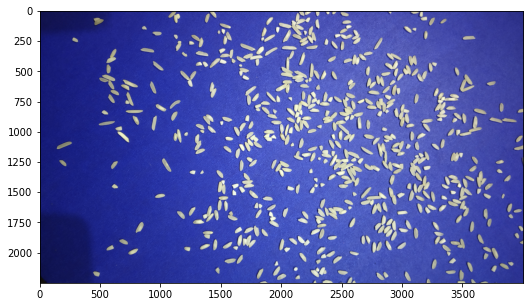

In [ ]:
#Reading Image
img = cv2.imread("/content/drive/MyDrive/Aman's_Akaike Assignment/CV_SOLUCTION/data/test/image_1.jpg")

#Using predefined show function for displaying the image
show(img,25,5)

### Converting Image into Grayscale and then Image Thresholding

The first step in Image Pre-processing is to convert the image into grayscale and to apply the threshold function the cv2.threshold()to separate pixels into the foreground, and the background areas.

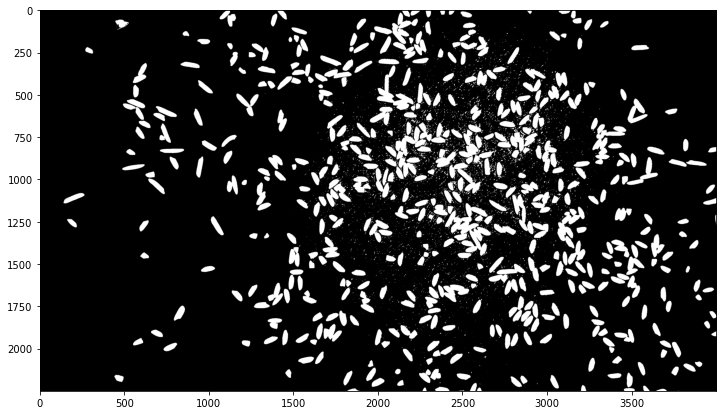

In [ ]:
#Converting Image BGR Image to Gray for Image thresholding and further Image-Preprocessing application
grayscale_Image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh_img = cv2.threshold(grayscale_Image, 120, 255, cv2.THRESH_BINARY)

#Using show function earlier defined
show(thresh_img)

### Noise Removal

To remove some noise from an image, the morphological function morphologyEx() can be Implemented.

This function can be used for several morphological operations, so there needed to add a parameter to specify which one can be taken.

Since the goal here is to remove the white ditorted reason the objectin the image.
Here, opening operation (erosion followed by dilation) is going to be in use.

In this case, we will use four iterations iterations=8 (to suppress larger noise areas we will use more iterations)

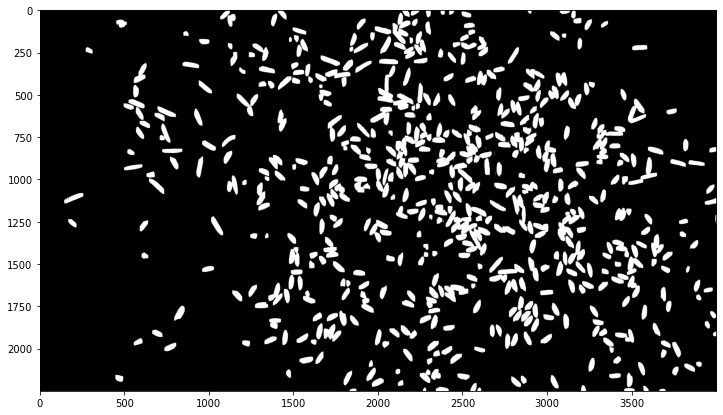

In [ ]:
# Noise removal
kernel = np.ones((3),np.uint8)
clear_image = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel, iterations=8)

#Using show function earlier defined
show(clear_image)

Image pre-processing is done now, and its time to apply the Grain counting algorithm.

### Counting the labels

In [ ]:
#Copying the preprocessed image as label_image
label_image = clear_image.copy()

#Creating a label_count variable to the count the number of grains in the image
label_count = 0

#Shape function for getting height and width
rows, cols = label_image.shape

#Looping through the pixel of image using rows and column of image
for j in range(rows):
    for i in range(cols):
        pixel = label_image[j, i]

        #Here there is single channel with 2 pixel intensities, Either 0 or 255. 0 represent black portion, where 255 represent grains (White).
        #Counting the total number of pixel with intensity 255
        if 255 == pixel:
            label_count += 1

            ##Applying floodFill method of opencv which will help in filling the backgroud that will ultimately helps in couting the contoured grain easily
            cv.floodFill(label_image, None, (i, j), label_count)


Number of foreground objects 516472


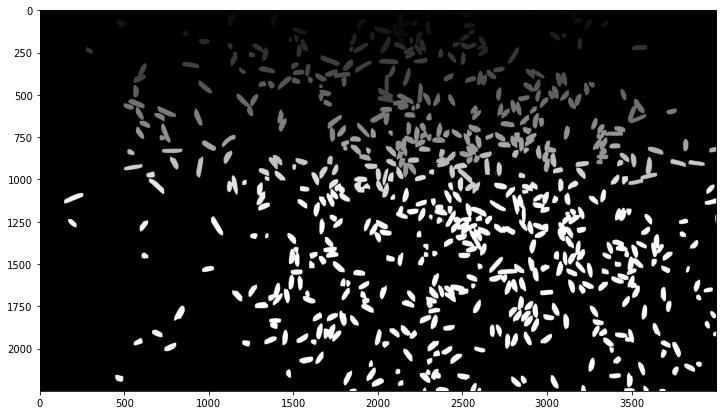

In [ ]:

print("Number of foreground objects", label_count)
show(label_image)

## STEP 4 - Counting rice grains using Contours method

Applying Opencv Contour method for counting the total number of rice grains avilable in the image. \
Contours are defined as the line joining all the points along the boundary of an image that are having the same intensity. 

In [ ]:
#Applying Countours method to get the count of rice grains
contours, hierarchy = cv.findContours(clear_image, 
                                      cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)


output_contour = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
cv.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
print("Number of detected contours", len(contours))

Number of detected contours 513


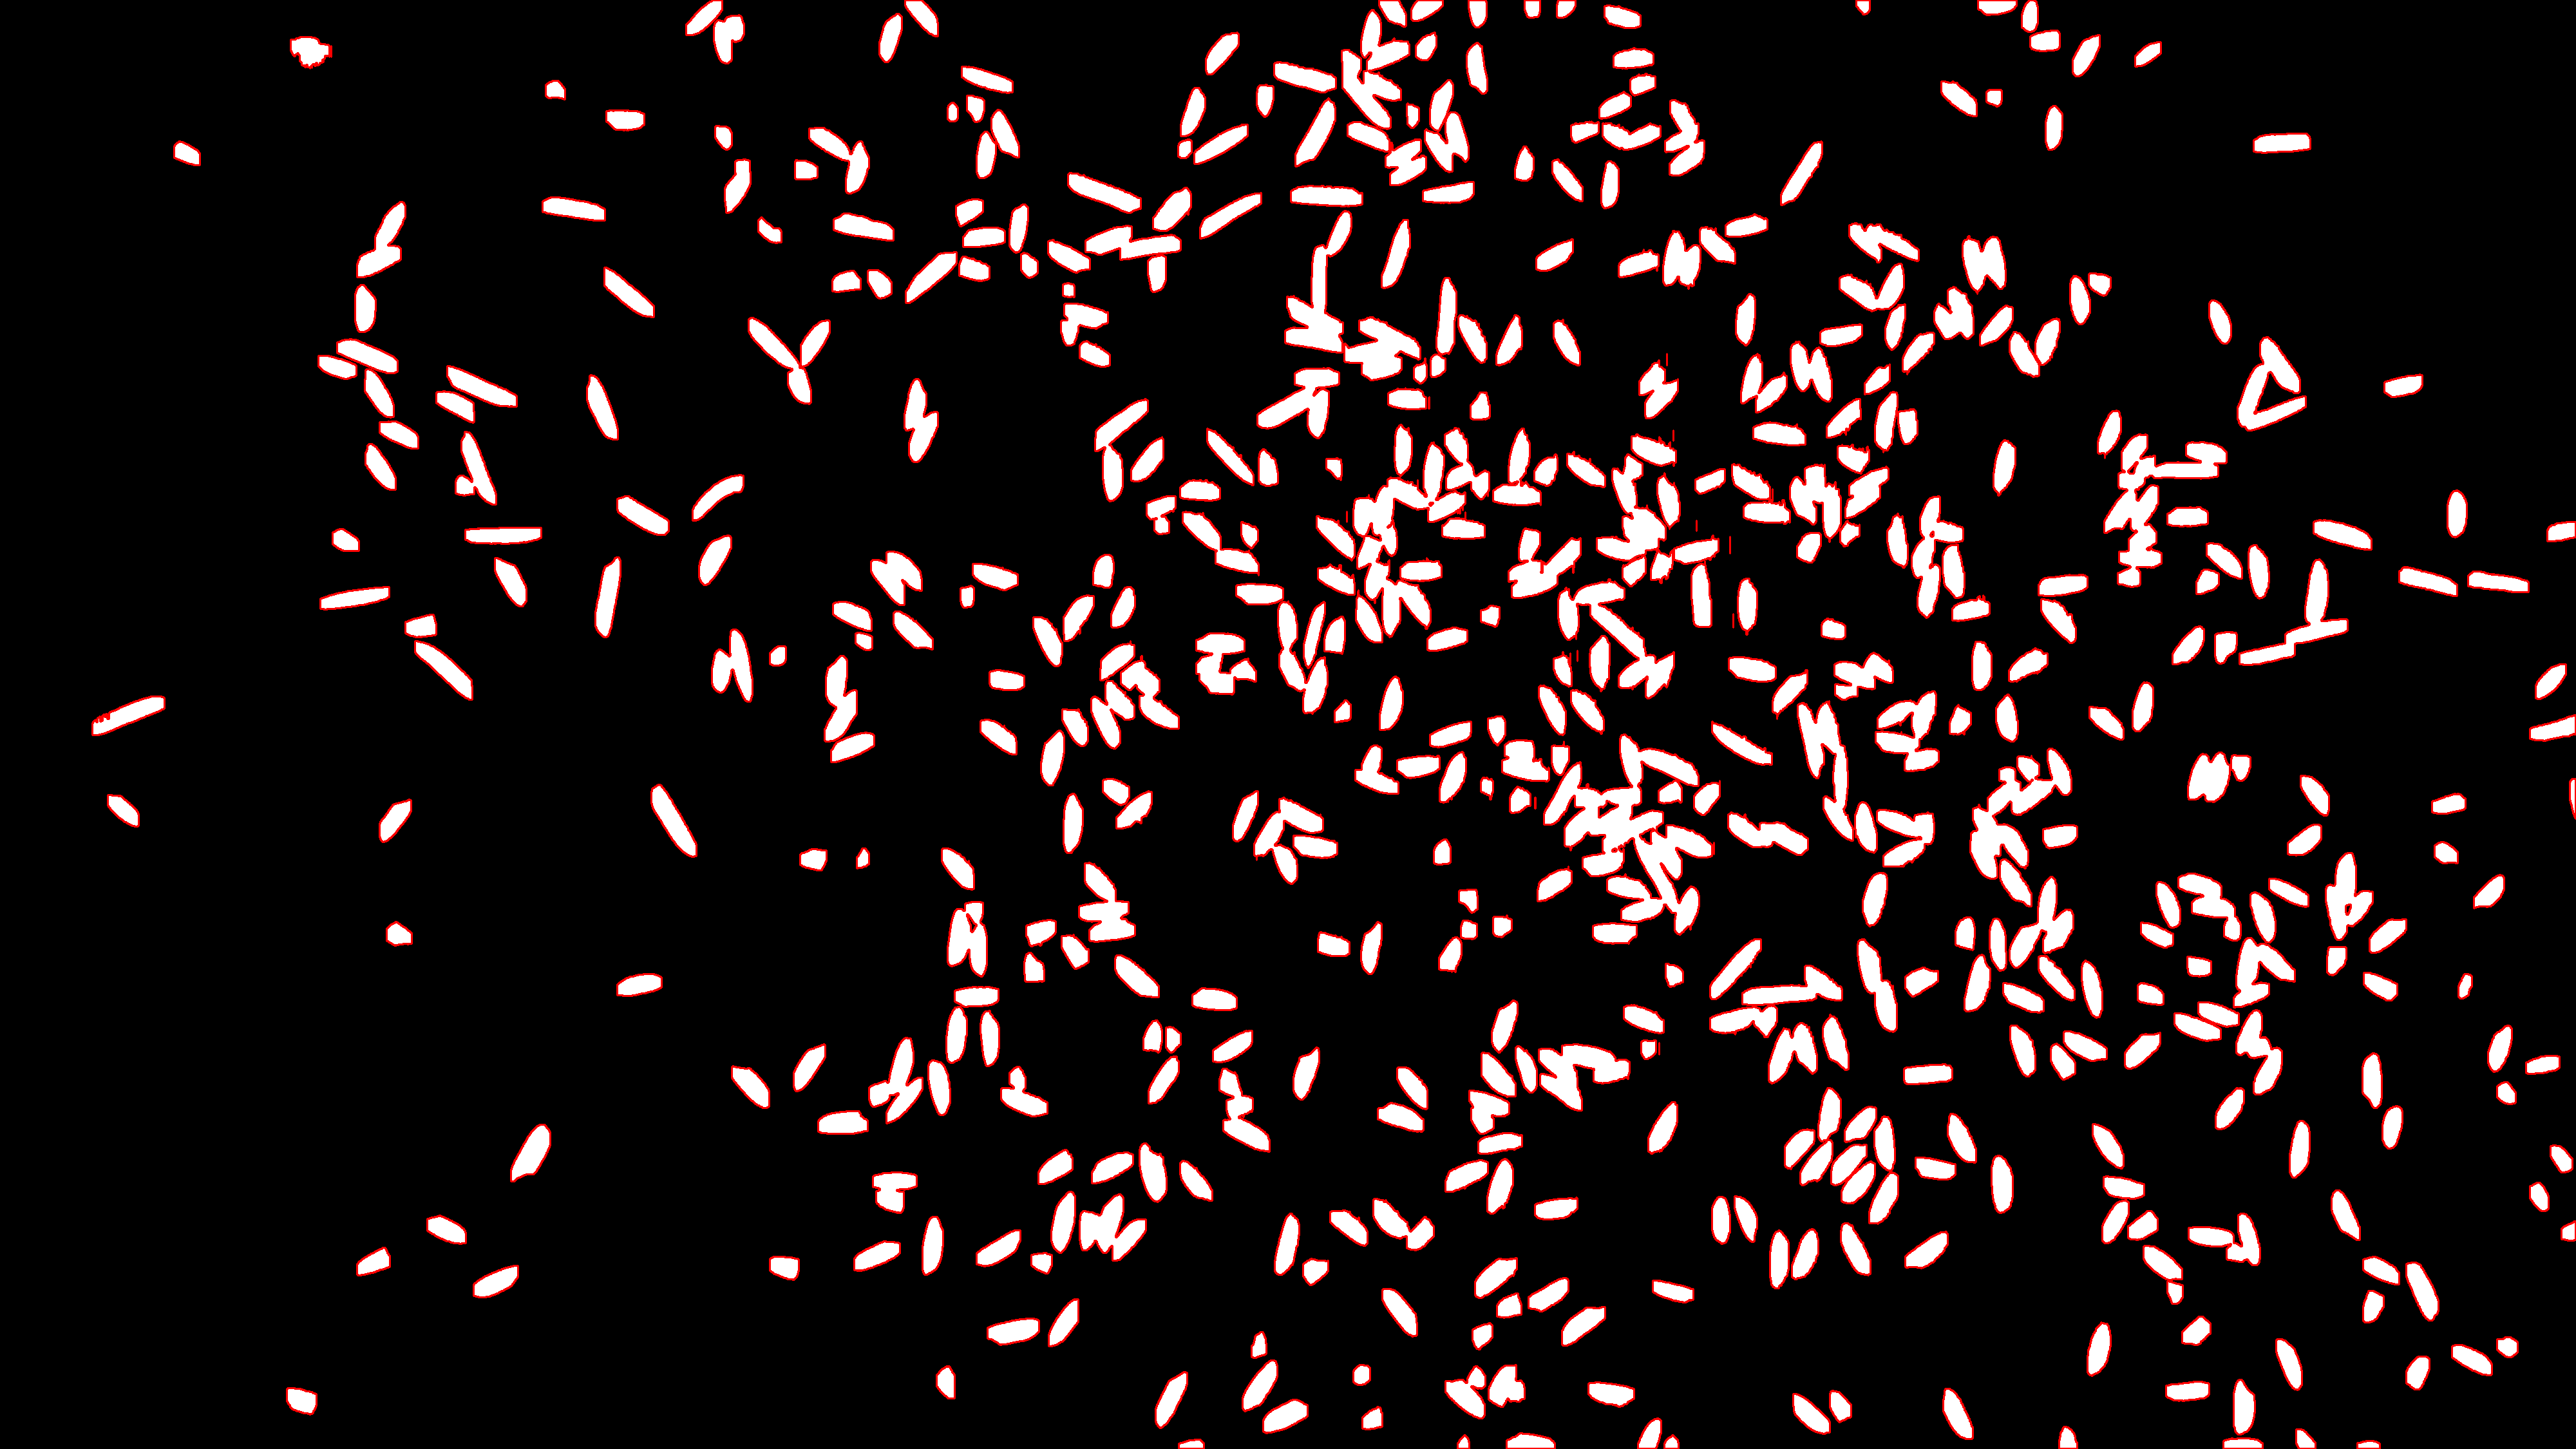

 
 Number of detected contours 513


In [ ]:
cv2_imshow(output_contour)

print(" \n Number of detected contours", len(contours))

Number of detected contours are 513, It denotes, total number of rice grain in the Image.


##Output_Contour Image Analysis
Looking at the ouput_image after applying contours that, there are some rice grains that are touching each other. 

And this situation making the Opencv Contour method to treat those images as collection or as 1 rice grain.

Well the amount of grains that are touching each other are very few but still there needed a fix for this.

### Time to fix the touching Rice grain problem!

## STEP 5 - Applying Watershed Algorithm 
Fixing rice grains Touching problem with "**WaterShed Algorithm**" \
Watershed algorithm is based on extracting sure background and foreground and then using markers will make watershed run and detect the exact boundaries. This algorithm generally helps in detecting touching and overlapping objects in image.




In [ ]:
#To visualize the segmentation conveniently, There needed a colour-code the labelled regions using the color, thus I did it.


#Applying  distance_transform_edt to computes the distance from non-zero (i.e. non-background) points to the nearest zero (i.e. background) point.
dist_trans = ndimage.distance_transform_edt(clear_image)

#Applying peak_local_max function for getting coordinates of local peaks (maxima) in an image.
local_max = feature.peak_local_max(dist_trans, min_distance=23)


local_max_mask = np.zeros(dist_trans.shape, dtype=bool)
local_max_mask[tuple(local_max.T)] = True

#Aplying Watershed algorithm
labels = watershed(-dist_trans, measure.label(local_max_mask), mask=clear_image) # separate merged corns


## STEP 6 - Counting Total Grains and Broken grains using grains area

Number of Rice grains are : 586


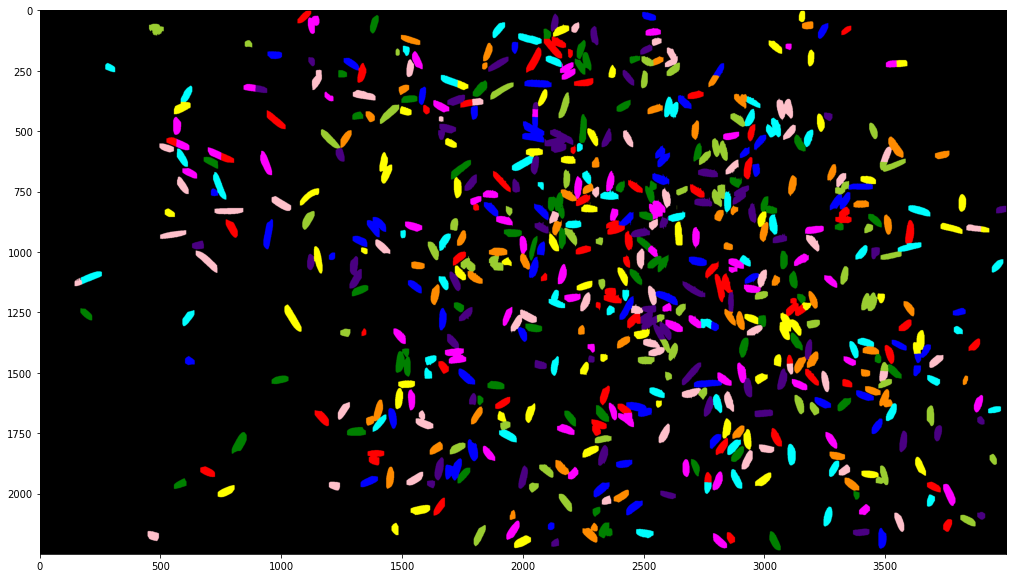

In [ ]:
#label2rgb function, specifying the background label with argument bg_label=0.
plt.figure(figsize=(30,10))
plt.imshow(color.label2rgb(labels, bg_label=0))
print("Number of Rice grains are : %d" % labels.max())

## Results of WaterShed Algorithm
The results are quite better after applying the Watershed algorithm. Most of the touching rice grains are well seperated now and counting is more accurate.

In the above results, there is the total counting of 513 and here, the count is of 589.

It means, there is total gap of 76 grains.

Well, the results are not 100% accurate but it is feasible in respect of Simple countous counting.

##Objective 1 : Count the Total number of Rice grains (Done) 💯

## Counting Broken Rice

After carefull analysis, I found that 800 is the threshold limit for classifing the broken rice grains from the Full rice grains.

Thus applying this limit on the contour to get the results.

In [ ]:
#Creating A list name count for counting the total Broken rice grains
count = []

#Iterating through contour and filtering out the rice grains with area less than 800 and then appending to the count variable.
for x in contours:

  #Using contourArea method to get the area of rice (Contour)
  area = cv.contourArea(x)
  if area < 800 :
    count.append(x)

#Output of the count list.

print("Total number of broken rice present in the Image is: ",len(count))

Total number of broken rice present in the Image is:  87


## Objective 2 : Count the Total number of Broken rice grains (Done) 💯

# Optional Approaches

#Method 2 (Split and count)

This method is based on splitting the image into sub-images and on that subpart by applying a rice grain counting algorithm with the use of OpenCV.

Well, 
This method is highly accurate for the small portion of the image and counting the grains on that but there comes an issue when trying to sum the count of overall rice grain in the image.

The major problem is the presence of rice grain in more than one sub-images. This problem increases the count of broken rice grain and total rice grain in the image because of repetition.

I have added the solution with this method too in the collab (Old Assignment), well because of an error, not considered it as the main solution.



## Method 3 (Neural Network training) 
I haven’t applied this method as part of the solution, but this method can also be one of the ways to tackle the problem statement.

Training a neural network on a custom dataset having well annotated full rice grain and broken rice grains images.

It will give the optimal solution with very less error.
I haven’t applied this as I haven’t found any pre-trained model or dataset for the following. But this method can be taken further to take into consideration.


#End Note
Thanks for going through the Solution, I believe you must have found this helpful.
I am quite confident about the apporach and find it one of the best to solve this problem.\
Well, there is always a scope of Improvement and for that,
I am looking further to hear your response.
Maybe meet you in person and discuss a better apporach.

Thank you,\
Aman India.